In [14]:
import pandas as pd

In [15]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [16]:
df = df.fillna(0)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9704 non-null   float64
 2   horsepower           9704 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         9704 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9704 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


In [18]:

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
y_train = (df_train["fuel_efficiency_mpg"])
y_val = (df_val["fuel_efficiency_mpg"])
y_test = (df_test["fuel_efficiency_mpg"])

In [21]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [23]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [26]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [27]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [32]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [34]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.ensemble import RandomForestRegressor


RF = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs = 1)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_val)
rmse_score = rmse(y_val, y_pred)


print(f"Root Mean Squared Error (RMSE): {rmse_score:.4f}")

Root Mean Squared Error (RMSE): 0.4600


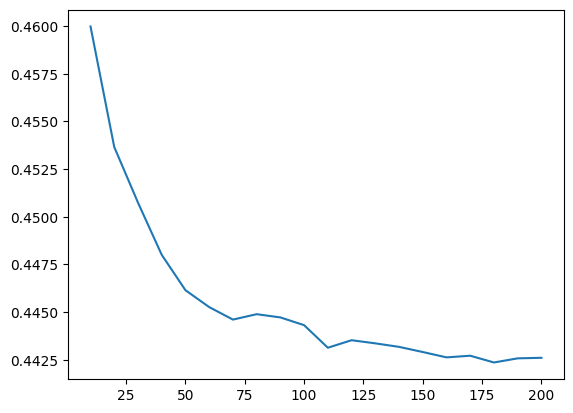

In [40]:
import numpy as np
import matplotlib.pyplot as plt

estimators = np.arange(10, 201, 10)
scores = []


for n in estimators:
  RF = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs = 1)
  RF.fit(X_train, y_train)

  y_pred = RF.predict(X_val)
  scores.append(rmse(y_val, y_pred))

plt.plot(estimators, scores)

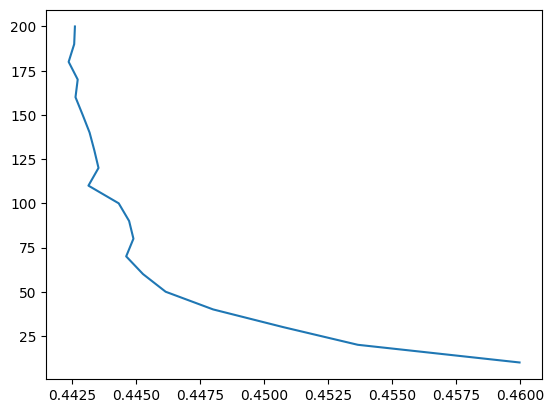

In [41]:
plt.plot(scores, estimators)

In [44]:
for i in range(len(scores)):
  print(round(scores[i],3), round(estimators[i],3))
  print()

0.46 10

0.454 20

0.451 30

0.448 40

0.446 50

0.445 60

0.445 70

0.445 80

0.445 90

0.444 100

0.443 110

0.444 120

0.443 130

0.443 140

0.443 150

0.443 160

0.443 170

0.442 180

0.443 190

0.443 200



In [45]:
import pandas as pd

depths = [10, 15, 20, 25]

scores = []

for d in depths:
  for n in estimators:
    RF = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs = 3)
    RF.fit(X_train, y_train)

    y_pred = RF.predict(X_val)
    scores.append((d, n, rmse(y_val, y_pred)))

columns = ['max_depth', 'n_estimators', 'rmse']
score_df = pd.DataFrame(scores, columns = columns)
score_df

,max_depth,n_estimators,rmse
0,10,10,0.451895
1,10,20,0.448719
2,10,30,0.446225
3,10,40,0.443877
4,10,50,0.442682
...,...,...,...
75,25,160,0.442689
76,25,170,0.442767
77,25,180,0.442415
78,25,190,0.442618


In [59]:
mean_rmse_by_depth = score_df.groupby('max_depth')['rmse'].mean().reset_index()
print(mean_rmse_by_depth)
print(np.argmin(mean_rmse_by_depth['rmse']))

   max_depth      rmse
0         10  0.442321
1         15  0.445060
2         20  0.445644
3         25  0.445661
0


In [49]:
RF = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs = -1)
RF.fit(X_train, y_train)

print(RF.feature_importances_)

[1.14707165e-02 3.81809750e-04 3.11842085e-04 3.26932342e-03
 3.43693411e-04 3.36671988e-04 1.60402148e-02 3.18229841e-03
 2.35867094e-03 1.59113306e-03 4.76103046e-04 5.20358083e-04
 5.55151959e-04 9.59162013e-01]


In [51]:
import pandas as pd



feature_names = list(dv.get_feature_names_out())
importances = RF.feature_importances_

feature_importances = pd.Series(importances, index=feature_names)
sorted_importances = feature_importances.sort_values(ascending=False)

print("--- Feature Importances (Random Forest) ---")
print(sorted_importances)

--- Feature Importances (Random Forest) ---
vehicle_weight                  0.959162
horsepower                      0.016040
acceleration                    0.011471
engine_displacement             0.003269
model_year                      0.003182
num_cylinders                   0.002359
num_doors                       0.001591
origin=USA                      0.000555
origin=Europe                   0.000520
origin=Asia                     0.000476
drivetrain=All-wheel drive      0.000382
fuel_type=Diesel                0.000344
fuel_type=Gasoline              0.000337
drivetrain=Front-wheel drive    0.000312
dtype: float64


In [52]:
!pip install xgboost

In [53]:
import xgboost as xgb


features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [55]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 2,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [57]:
y_pred = model.predict(dval)

print(rmse(y_val, y_pred))

0.45017755678087246


In [58]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 2,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)

print(rmse(y_val, y_pred))

0.42622800553359225
